In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

class GeneticAlgorithm:
    def __init__(self, fitness_func, param_ranges, X_train, y_train, X_test, y_test, population_size=20, generations=50, mutation_rate=0.1, tournament_size=3):
        self.fitness_func = fitness_func
        self.param_ranges = param_ranges
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size

    def initialize_population(self):
        """Khởi tạo quần thể ban đầu với các giá trị ngẫu nhiên."""
        population = []
        for _ in range(self.population_size):
            individual = [np.random.uniform(low, high) for low, high in self.param_ranges]
            population.append(individual)
        return np.array(population)

    def tournament_selection(self, population, fitness):
        """Chọn cha mẹ sử dụng phương pháp tournament selection."""
        selected_parents = []
        for _ in range(2):  # Chọn 2 cha mẹ
            tournament_idx = np.random.choice(range(len(population)), self.tournament_size, replace=False)
            tournament_fitness = fitness[tournament_idx]
            winner_idx = tournament_idx[np.argmin(tournament_fitness)]  # Cá thể tốt nhất trong tournament
            selected_parents.append(population[winner_idx])
        return selected_parents

    def crossover(self, parent1, parent2):
        """Thực hiện crossover giữa hai cá thể cha mẹ (crossover đa điểm)."""
        crossover_points = np.sort(np.random.choice(len(parent1), 2, replace=False))  # Chọn 2 điểm crossover
        child1 = np.concatenate((parent1[:crossover_points[0]], parent2[crossover_points[0]:crossover_points[1]], parent1[crossover_points[1]:]))
        child2 = np.concatenate((parent2[:crossover_points[0]], parent1[crossover_points[0]:crossover_points[1]], parent2[crossover_points[1]:]))
        return child1, child2

    def mutate(self, individual):
        """Đột biến cá thể với tỷ lệ đột biến nhất định."""
        if np.random.rand() < self.mutation_rate:
            mutation_idx = np.random.randint(len(individual))
            individual[mutation_idx] = np.random.uniform(*self.param_ranges[mutation_idx])
        return individual

    def run(self):
        population = self.initialize_population()
        best_fitness = float('inf')
        generations_without_improvement = 0  # Số thế hệ không có sự cải thiện nào

        for generation in range(self.generations):
            # Cập nhật hàm fitness với đối tượng 'self' (ga_instance)
            fitness = np.array([self.fitness_func(ind, self) for ind in population])
            best_generation_fitness = np.min(fitness)

            if best_generation_fitness < best_fitness:
                best_fitness = best_generation_fitness
                generations_without_improvement = 0  # Reset khi có cải thiện
            else:
                generations_without_improvement += 1

            # Điều kiện dừng sớm nếu không có sự cải thiện đáng kể trong một số thế hệ
            if generations_without_improvement > 10:
                print(f"Stopping early at generation {generation} due to no improvement.")
                break

            next_population = []
            for _ in range(self.population_size // 2):
                parents = self.tournament_selection(population, fitness)
                child1, child2 = self.crossover(parents[0], parents[1])
                next_population.extend([self.mutate(child1), self.mutate(child2)])

            population = np.array(next_population)

        best_individual = population[np.argmin([self.fitness_func(ind, self) for ind in population])]
        return best_individual


In [2]:
# Hàm fitness để đánh giá độ chính xác của mô hình SVM
def fitness_func(params, ga_instance):
    """Hàm fitness nhận vào các tham số của SVM và đánh giá hiệu quả."""
    C = params[0]
    gamma = params[1]

    # Khởi tạo mô hình SVM với tham số C và gamma
    model = SVC(C=C, gamma=gamma)

    # Huấn luyện mô hình trên dữ liệu huấn luyện
    model.fit(ga_instance.X_train, ga_instance.y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(ga_instance.X_test)

    # Tính độ chính xác (fitness là độ chính xác của mô hình)
    accuracy = accuracy_score(ga_instance.y_test, y_pred)
    return 1 - accuracy  # Mục tiêu là tối thiểu hóa (fitness thấp nhất tương ứng với độ chính xác cao nhất)

Độ chính xác của mô hình SVC trước khi được tối ưu hóa bởi GA: 0.6228070175438597
Stopping early at generation 11 due to no improvement.
Giá trị các siêu tham số tối ưu tìm được: 
Best C: 15.84878531765029, Best Gamma: 0.13102603700398963
Độ chính xác của mô hình SVC sau khi được tối ưu hóa bởi GA: 0.956140350877193


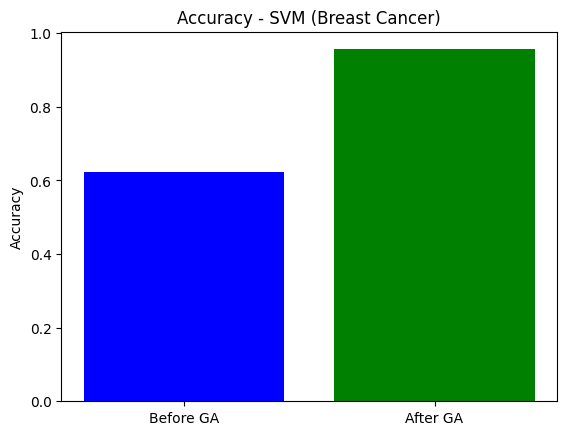

In [4]:
import matplotlib.pyplot as plt

# Tải dữ liệu breast_cancer từ sklearn
data = load_breast_cancer()
X = data.data
y = data.target

# Tiền xử lý dữ liệu (chuẩn hóa dữ liệu)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Trước GA
svm_model = SVC(random_state=42, C=np.random.uniform(0.1, 100), gamma=np.random.uniform(1e-5, 1))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
acc_before = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình SVC trước khi được tối ưu hóa bởi GA: {acc_before}")

# Xác định dải giá trị cho các tham số C và gamma của SVM
param_ranges = [(0.1, 100), (1e-5, 1)]  # C và gamma

# Khởi tạo và chạy thuật toán di truyền để tối ưu tham số SVM
ga = GeneticAlgorithm(fitness_func, param_ranges, X_train, y_train, X_test, y_test, population_size=20, generations=50, mutation_rate=0.1)
best_params = ga.run()

# In kết quả tối ưu
best_C = best_params[0]
best_gamma = best_params[1]
print("Giá trị các siêu tham số tối ưu tìm được: ")
print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

# Huấn luyện lại mô hình SVM với tham số tối ưu
best_model = SVC(C=best_C, gamma=best_gamma)
best_model.fit(X_train, y_train)

# Đánh giá mô hình trên tập kiểm tra
y_pred = best_model.predict(X_test)
acc_after = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình SVC sau khi được tối ưu hóa bởi GA: {acc_after}")


# Plotting
plt.bar(['Before GA', 'After GA'], [acc_before, acc_after], color=['blue', 'green'])
plt.title('Accuracy - SVM (Breast Cancer)')
plt.ylabel('Accuracy')
plt.show()
